# Table of contents
* [Preparing the data and plots](#preparing)
* [Psychometric function](#psychometrics)
* [Probability of CoM trials](#p_com)
* [Probability of CoM trials depending on initation times](#p_com_IT)
* [Probability of CoM trials (obsolete)](#p_com_obsolete)

<a name="preparing"></a>
# Preparing data and plots
First, we import the basic modules and tweak figure display parameters

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML

#set precision for displaying float-point values in the notebook
pd.options.display.float_format = '{:,.3f}'.format

#set figure dpi to 100 to get reasonably sized figures displayed in the notebook
plt.rc('figure', dpi=100)

#set savefig dpi to 300 to get high-quality images to insert in the paper
plt.rc('savefig', dpi=300)

#set to 'pdf' or 'eps' for vector figures or to 'png'
plt.rc('savefig', format='png')

# despine plots by default
plt.rc("axes.spines", top=False, right=False)

#set font sizes for figures throughout
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('axes', labelsize=20, titlesize=22)
plt.rc('legend', fontsize=16)

# color palette for sequential data
palette_sqn = 'viridis_r'

# color palette for participant IDs
palette_subj = 'magma_r'

Then, we read the data (assuming it's already pre-processed). Change the path to the files if necessary

In [2]:
import data_reader
dr = data_reader.DataReader()

# if Exp1 and Exp2 data need to be plotted alongside each other, read those data into separate dataframes
exp_1, exp_2 = 'exp_1', 'exp_2'
choices_1, dynamics_1 = dr.get_data(path='../../data/HEM_%s/processed/' % (exp_1))
choices_2, dynamics_2 = dr.get_data(path='../../data/HEM_%s/processed/' % (exp_2))

<a name="psychometrics"></a>
# Psychometric function

Plot individual psychometric functions separately for CoM and no-CoM trials (NB: this has been broken by a recent update of seaborn and matplotlib. TODO: investigate the issue, has something to do with automatically generated plot legends)

In [ ]:
def plot_psychometric_function_individual(c, color, marker):
    psf = [len(c[(c.is_correct) & (c.coherence==coherence) & (c.is_com==is_com)]) / 
                   len(c[(c.coherence==coherence) & (c.is_com==is_com)]) 
               if len(c[(c.coherence==coherence) & (c.is_com==is_com)]) else np.NaN 
           for coherence in np.sort(c.coherence.unique()) 
           for is_com in np.sort(c.is_com.unique())]
    
    p_correct = pd.DataFrame(psf, columns=['p_correct'], 
                        index=pd.MultiIndex.from_product([np.sort(c.coherence.unique()), 
                                                          np.sort(c.is_com.unique())], 
                                                         names=['coherence', 'is_com']))
    
    ax = sns.pointplot(data=p_correct.reset_index(), x='coherence', y='p_correct', hue='is_com',
                       palette=[color, color], linestyles=['-', '--'], markers=[marker, marker], 
                       scale=0.75)
    
    ax.set_xlabel('coherence')
    ax.set_ylabel('p(correct)')
    ax.legend(handles=ax.lines[::len(c.coherence.unique())+1], labels=['no-com','com'])
    
    return ax

def plot_psychometric_functions(choices, exp):
    plt.figure()
    choices = choices[~(choices.coherence==0)]
#     colors = ['C0', 'C1', 'C2', 'C3']
    markers = ['x','o','v','s']
    colors = sns.color_palette(palette_subj, 4)
    for i, subj_id in enumerate(np.sort(choices.index.get_level_values('subj_id').unique().values)):
        ax = plot_psychometric_function_individual(choices.loc[subj_id], color=colors[i], marker=markers[i])
    ax.set_ylim([-0.02, 1.02])
    plt.title(exp)
    plt.savefig('figures/psychometric_function_individual_%s' % (exp), bbox_inches='tight')

# plot_psychometric_functions(choices_1, exp_1)
# plot_psychometric_functions(choices_2, exp_2)

Note that as Participant 275 (green lines) has very few CoMs, their psychometric function is very noisy, especially at higher coherence levels. For this reason, we probably won't be able to fit the model to this individual, and also maybe Participant 451. If we don't do individual fits though, we can just fit to psychometric function calculated for all participant within an experiment. This is what it looks like

In [ ]:
def plot_psychometric_function_aggregate(c, exp, color='k'):
    plt.figure()
    c = c[~(c.coherence==0)]
    psf = [len(c[(c.is_correct) & (c.coherence==coherence) & (c.is_com==is_com)]) / 
                   len(c[(c.coherence==coherence) & (c.is_com==is_com)]) 
               if len(c[(c.coherence==coherence) & (c.is_com==is_com)]) else np.NaN  
           for coherence in np.sort(c.coherence.unique()) 
           for is_com in np.sort(c.is_com.unique())]
    
    p_correct = pd.DataFrame(psf, columns=['p_correct'], 
                        index=pd.MultiIndex.from_product([np.sort(c.coherence.unique()), 
                                                          np.sort(c.is_com.unique())], 
                                                         names=['coherence', 'is_com']))
    ax = sns.pointplot(data=p_correct.reset_index(), x='coherence', y='p_correct', hue='is_com',
                       palette=[color, color], linestyles=['-', '--'], scale = 0.75)
    
    ax.set_xlabel('coherence')
    ax.set_ylabel('p(correct)')
    ax.legend(handles=ax.lines[::len(c.coherence.unique())+1], labels=['no-com','com'])
    plt.title(exp)
    plt.savefig('figures/psychometric_function_%s' % (exp), bbox_inches='tight')
    return ax

plot_psychometric_function_aggregate(choices_1, exp_1)
plot_psychometric_function_aggregate(choices_2, exp_2)

Let's look at the same psychometric functions with [binomial proportion confidence intervals](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval). 

Following Resulaj et al (2009), whiskers denote s.e.m. (rather than 95% CI).

In [ ]:
def get_ci(c):
    psf = np.array([len(c[(c.is_correct) & (c.coherence==coherence) & (c.is_com==is_com)]) / 
                   len(c[(c.coherence==coherence) & (c.is_com==is_com)]) 
               if len(c[(c.coherence==coherence) & (c.is_com==is_com)]) else np.NaN  
           for coherence in np.sort(c.coherence.unique()) 
           for is_com in np.sort(c.is_com.unique())])
    n = [len(c[(c.coherence==coherence) & (c.is_com==is_com)]) 
                      for coherence in np.sort(c.coherence.unique()) 
                      for is_com in np.sort(c.is_com.unique())]

    ci = pd.DataFrame(psf, columns=['p_correct'], 
                        index=pd.MultiIndex.from_product([np.sort(c.coherence.unique()), 
                                                          np.sort(c.is_com.unique())], 
                                                         names=['coherence', 'is_com']))
    ci['ci_l'] = ci['p_correct'] - np.sqrt(psf*(1-psf)/n)
    ci['ci_r'] = ci['p_correct'] + np.sqrt(psf*(1-psf)/n)
    
    return ci.reset_index()

def plot_psychometric_function_ci(choices, exp):
    choices = choices[~(choices.coherence==0)]
    ax = plot_psychometric_function_aggregate(choices, exp)
    ci = get_ci(choices)
    ax.vlines(x=[val for pair in zip(range(0,5), range(0,5)) for val in pair], 
              ymin=ci.ci_l, ymax=ci.ci_r, color='k', zorder=10)
    plt.title(exp)
    ax.set_ylim(0.35, 1.05)
    plt.savefig('figures/psychometric_function_ci_%s' % (exp), bbox_inches='tight')
    
plot_psychometric_function_ci(choices_1, exp_1)
plot_psychometric_function_ci(choices_2, exp_2)

<a name="p_com"></a>
# Probability of CoM

First, let's take a look at number of correct/error CoM at each coherence level

In [ ]:
def plot_n_com_by_is_correct(c, exp, color='k'):
    plt.figure()
    c = c[~(c.coherence==0)]
    n_com = [len(c[(c.is_com) & (c.coherence==coherence) & (c.is_correct==is_correct)])
           for coherence in np.sort(c.coherence.unique()) 
           for is_correct in np.sort(c.is_correct.unique())]
    
    n_com = pd.DataFrame(n_com, columns=['n_com'], 
                        index=pd.MultiIndex.from_product([np.sort(c.coherence.unique()), 
                                                          np.sort(c.is_correct.unique())], 
                                                         names=['coherence', 'is_correct']))
    ax = sns.pointplot(data=n_com.reset_index(), x='coherence', y='n_com', hue='is_correct',
                       palette=[color, color], linestyles=['-', '--'], scale = 0.75)
    
    print(exp, n_com)
    
    ax.axhline(10)
    ax.set_xlabel('coherence')
    ax.set_ylabel('number of CoM')
    ax.set_ylim((0, 40))
    ax.legend(handles=ax.lines[::len(c.coherence.unique())+1], labels=['error','correct'])
    plt.title(exp)
    plt.savefig('figures/n_com_by_is_correct_%s' % (exp), bbox_inches='tight')
    return ax

plot_n_com_by_is_correct(choices_1, exp_1)
plot_n_com_by_is_correct(choices_2, exp_2)

In Experiment 1 we have fewer CoM's at higher coherences, compared to Experiment 2. For instance, at 0.512 coherence we have just 3 CoM's in Exp 1, and 20 CoM's in Exp 2. Naturally, with these numbers p(CoM) is going to be very noisy, so we discard the conditions with less than 10 data points (below blue lines in the plots above)

In [ ]:
def plot_p_com_by_is_correct(c, exp, color='k', n_threshold = 5):
    plt.figure()

    p_com_total = [(len(c[(c.is_com) & (c.coherence==coherence)]) / len(c[(c.coherence==coherence)]), coherence)
               if (len(c[(c.is_com) & (c.coherence==coherence)]) > n_threshold) else (np.NaN, coherence)
           for coherence in np.sort(c.coherence.unique())]
    
    p_com_total = pd.DataFrame(p_com_total, columns=['p_com', 'coherence'])
    
    ax = sns.pointplot(data=p_com_total, x='coherence', y='p_com', scale=0.75, color='gray')
    
#     c = c[~(c.coherence==0)]
    p_com = [len(c[(c.is_com) & (c.coherence==coherence) & (c.is_correct==is_correct)]) / 
                   len(c[(c.coherence==coherence)]) 
               if (len(c[(c.is_com) & (c.coherence==coherence) & (c.is_correct==is_correct)]) > n_threshold) else np.NaN  
           for coherence in np.sort(c.coherence.unique()) 
           for is_correct in np.sort(c.is_correct.unique())]
    
    p_com = pd.DataFrame(p_com, columns=['p_com'], 
                        index=pd.MultiIndex.from_product([np.sort(c.coherence.unique()), 
                                                          np.sort(c.is_correct.unique())], 
                                                         names=['coherence', 'is_correct']))
    p_com.loc[0] = np.NaN
   
    ax = sns.pointplot(data=p_com.reset_index(), x='coherence', y='p_com', hue='is_correct',
                       palette=[color, color], linestyles=['-', '--'], scale=0.75, ax=ax)
        
    ax.set_xlabel('coherence')
    ax.set_ylabel('p(CoM)')
    ax.set_ylim((-0.005, 0.06))
  
    plt.title(exp)
    plt.savefig('figures/p_com_by_is_correct_%s' % (exp), bbox_inches='tight')
    return ax

plot_p_com_by_is_correct(choices_1, exp_1, n_threshold=0)
plot_p_com_by_is_correct(choices_2, exp_2, n_threshold=0)

Still, this kind of plot seems to be quite noisy for error trials, as we need to divide N(CoM) by N(error), which is relatively small at high coherences. In psychometric functions, we divide by N(CoM), which also can be small though.

We can also take a look at unfiltered data, and indicate uncertainty with confidence intervals  like we did in the psychometric function plots

In [ ]:
def get_ci_p_com(c, n_threshold=10):
    p_com = np.array([len(c[(c.is_com) & (c.coherence==coherence) & (c.is_correct==is_correct)]) / 
                   len(c[(c.coherence==coherence)]) 
               if (len(c[(c.is_com) & (c.coherence==coherence) & (c.is_correct==is_correct)])>n_threshold) else np.NaN  
           for coherence in np.sort(c.coherence.unique()) 
           for is_correct in np.sort(c.is_correct.unique())])
    
    n = [len(c[(c.coherence==coherence) & (c.is_correct==is_correct)]) 
                      for coherence in np.sort(c.coherence.unique()) 
                      for is_correct in np.sort(c.is_correct.unique())]

    ci = pd.DataFrame(p_com, columns=['p_com'], 
                        index=pd.MultiIndex.from_product([np.sort(c.coherence.unique()), 
                                                          np.sort(c.is_correct.unique())], 
                                                         names=['coherence', 'is_correct']))
    ci['ci_l'] = ci['p_com'] - np.sqrt(p_com*(1-p_com)/n)
    ci['ci_r'] = ci['p_com'] + np.sqrt(p_com*(1-p_com)/n)
    
    return ci.reset_index()

def get_ci_p_com_total(c, n_threshold=10):
    p_com_total = [(len(c[(c.is_com) & (c.coherence==coherence)]) / len(c[(c.coherence==coherence)]), coherence)
               if (len(c[(c.is_com) & (c.coherence==coherence)]) > n_threshold) else (np.NaN, coherence)
           for coherence in np.sort(c.coherence.unique())]
    
    n = [len(c[(c.coherence==coherence)]) for coherence in np.sort(c.coherence.unique())]
    
    ci = pd.DataFrame(p_com_total, columns=['p_com', 'coherence'])  
    
    p_com = ci.p_com
    ci['ci_l'] = ci['p_com'] - np.sqrt(p_com*(1-p_com)/n)
    ci['ci_r'] = ci['p_com'] + np.sqrt(p_com*(1-p_com)/n)
    
    return ci.reset_index()

def plot_p_com_ci(choices, exp, n_threshold=10):
    ax = plot_p_com_by_is_correct(choices, exp, n_threshold=n_threshold)

    ci_total = get_ci_p_com_total(choices, n_threshold=n_threshold)
    ax.vlines(x=range(0,6), ymin=ci_total.ci_l, ymax=ci_total.ci_r, color='gray', zorder=10)
    
    ci = get_ci_p_com(choices, n_threshold=n_threshold)
    ax.vlines(x=[val for pair in zip(range(1,6), range(1,6)) for val in pair], 
              ymin=ci[ci.coherence>0].ci_l, ymax=ci[ci.coherence>0].ci_r, color='k', zorder=10)

    plt.title(exp)
    ax.set_ylim(-0.005, 0.06)
    
    ax.legend(handles=ax.lines[::len(choices.coherence.unique())+1], labels=['total', 'error','correct'])
    
    plt.savefig('figures/p_com_by_is_correct_ci_%s' % (exp), bbox_inches='tight')
    
plot_p_com_ci(choices_1, exp_1, n_threshold=0)
plot_p_com_ci(choices_2, exp_2, n_threshold=0)

<a name="p_com_IT"></a>
# Probability of CoM trials depending on initiation times

Let's look at probability of CoM for trials with different initation times

In [20]:
for choices in [choices_1, choices_2]:
    choices['mouse_IT_tertile'] = pd.qcut(choices['mouse_IT'], 3, labels=[1, 2, 3])
    choices['eye_IT_tertile'] = pd.qcut(choices['eye_IT'], 3, labels=[1, 2, 3])

coherence  mouse_IT_tertile
0.000      1                    299
           2                    552
           3                    749
0.032      1                    292
           2                    564
           3                    744
0.064      1                    330
           2                    571
           3                    699
0.128      1                    415
           2                    625
           3                    560
0.256      1                    705
           2                    530
           3                    365
0.512      1                   1159
           2                    358
           3                     83
dtype: int64
coherence  mouse_IT_tertile
0.000      1                   289
           2                   421
           3                   490
0.032      1                   275
           2                   434
           3                   491
0.064      1                   300
           2                   405
   

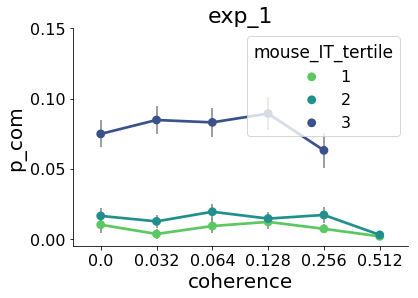

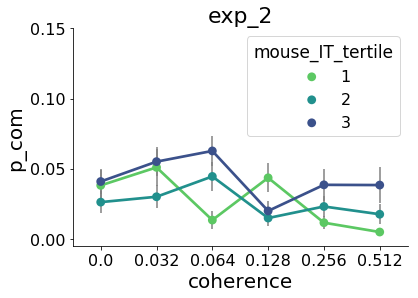

In [22]:
def get_ci_vs_var(c, var, n_threshold=0):
    p_com = c.groupby(by=['coherence', var]).apply(lambda c: len(c[c.is_com])/len(c) if len(c[c.is_com]) else np.NaN).rename('p_com')
    n = c.groupby(by=['coherence', var]).apply(len)
    print(n)
    ci = pd.DataFrame(p_com, columns=['p_com'], 
                        index=pd.MultiIndex.from_product([np.sort(c.coherence.unique()), 
                                                          np.sort(c[var].unique())], 
                                                         names=['coherence', var]))
    
    ci['ci_l'] = ci['p_com'] - np.sqrt(p_com*(1-p_com)/n)
    ci['ci_r'] = ci['p_com'] + np.sqrt(p_com*(1-p_com)/n)

    return ci.reset_index()
    
def plot_p_com_vs_var_ci(choices, var, exp, n_threshold=0):
    plt.figure()
    ci = get_ci_vs_var(choices, var, n_threshold=n_threshold)

    ax = sns.pointplot(data=ci, x='coherence', y='p_com', hue=var, palette=palette_sqn)
    ax.vlines(x=[val for pair in zip(range(0,6), range(0,6), range(0,6)) for val in pair], 
              ymin=ci.ci_l, ymax=ci.ci_r, color='gray', zorder=0)

    plt.title(exp)
    ax.set_ylim(-0.005, 0.15)
    
    plt.savefig('figures/p_com_by_%s_ci_%s' % (var, exp), bbox_inches='tight')    

plot_p_com_vs_var_ci(choices_1, 'mouse_IT_tertile', exp_1, n_threshold=0)
plot_p_com_vs_var_ci(choices_2, 'mouse_IT_tertile', exp_2, n_threshold=0)

In Experiment 1, the pattern is opposite to that in SI Fig. 3 from Resulaj et al (2009). However, there is no such pattern in Experiment 2. This is possibly due to our manipulation of late responses in Exp 2. 

In constrast, changes-of-mind do become more frequent with longer initiation if we look at eye latency:

coherence  eye_IT_tertile
0.000      1                  283
           2                  601
           3                  716
0.032      1                  310
           2                  599
           3                  691
0.064      1                  316
           2                  633
           3                  649
0.128      1                  455
           2                  577
           3                  568
0.256      1                  735
           2                  469
           3                  396
0.512      1                 1100
           2                  319
           3                  179
dtype: int64
coherence  eye_IT_tertile
0.000      1                 264
           2                 393
           3                 514
0.032      1                 265
           2                 405
           3                 496
0.064      1                 278
           2                 413
           3                 471
0.128      1              

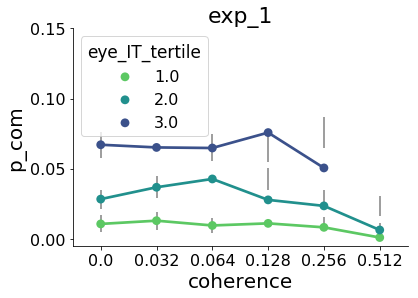

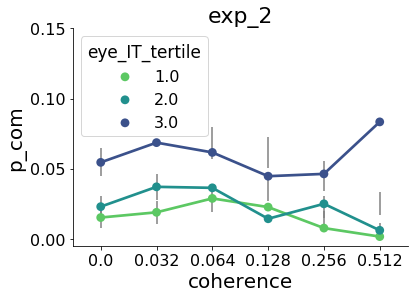

In [23]:
plot_p_com_vs_var_ci(choices_1, 'eye_IT_tertile', exp_1)
plot_p_com_vs_var_ci(choices_2, 'eye_IT_tertile', exp_2)

<a name="p_com_obsolete"></a>
# Probability of CoM trials (obsolete)

In [ ]:
def plot_n_com_vs_coherence(choices, exp):
    plt.figure()
    com_count = choices.groupby(by=['subj_id', 'coherence']).apply(lambda c: len(c[c.is_com])).rename('com_count')
    ax = sns.pointplot(data=com_count.reset_index(), x='coherence', y='com_count', hue='subj_id', 
                       ci=None, scale=1, palette=palette_subj)
    ax.set_xlabel('Coherence')
    ax.set_ylabel('N(CoM)')
    ax.set_ylim([-1, 42])
    plt.title(exp)
    plt.savefig('figures/n_com_vs_coherence_%s' % (exp), bbox_inches='tight')

plot_n_com_vs_coherence(choices_1, exp_1)
plot_n_com_vs_coherence(choices_2, exp_2)

Overall proportion of CoM trials is:

In [ ]:
print(len(choices_1[choices_1.is_com])/len(choices_1))
print(len(choices_2[choices_2.is_com])/len(choices_2))

Let's take a look at probability of change-of-mind for each individual participant

In [ ]:
def print_p_com(choices):
#     print(choices.groupby(level='subj_id').is_com.mean().rename('p_com').to_frame())
    display(HTML(choices.groupby(level='subj_id').is_com.mean().rename('p_com').to_frame().
                 to_html(formatters={'p_com': '{:,.1%}'.format})))

print_p_com(choices_1)
print_p_com(choices_2)

In [ ]:
def plot_p_com_vs_coherence(choices, exp):
    plt.figure()
    p_com = choices.groupby(by=['subj_id', 'coherence']).apply(lambda c: len(c[c.is_com])/len(c)).rename('p_com')
    ax = sns.pointplot(data=p_com.reset_index(), x='coherence', y='p_com', hue='subj_id', ci=None, palette=palette_subj)
    ax.set_xlabel('Coherence')
    ax.set_ylabel('P(CoM)')
    ax.set_ylim([-0.005, 0.11]);
    plt.title(exp)
    plt.savefig('figures/p_com_vs_coherence_%s' % (exp), bbox_inches='tight')

plot_p_com_vs_coherence(choices_1, exp_1)
plot_p_com_vs_coherence(choices_2, exp_2)